# Basic usage of PASSAGE

In this tutorial, we show how to employ `PASSAGE` to explore phenotype-associated spatial signatures, using two 10x Visium squamous cell carcinoma datasets, oral squamous cell carcinoma from [Rohit Arora, et.al](https://www.nature.com/articles/s41467-023-40271-4) and cutaneous squamous cell carcinoma from [Andrew L. Ji, et al.](https://www.sciencedirect.com/science/article/pii/S0092867420306723) as an example. 

## Dependencies

In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import glob
import torch
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np

import PASSAGE
from PASSAGE.model import Cal_Spatial_Net, scanpy_workflow, Transfer_pyg_Data, generate_single, generate_contrastive, run_PASSAGE
from PASSAGE.viz import generate_representation, view_embedding, view_pattern

PASSAGE.__version__

'1.0.0'

## Dataset Loading and Preparation

Here, we start with `AnnData` objects of spatial transcriptomic data (See `AnnData` [documentation](https://anndata.readthedocs.io/en/latest/index.html) for more details if you are unfamiliar), which is the standard data class we use throughout `PASSAGE`

First, we load the spatial trascriptomics data which could be downloaded is the following link after preprocessing:
- Class-1: Oral Squamous Cell Carcinoma, download from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE208253)
- Class-2: Cutaneous Squamous Cell Carcinoma, download from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE144240)

In [3]:
section_ids = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6',
               'S_7', 'S_8', 'S_9', 'S_10', 'S_11', 'S_12',
               'P2_rep1', 'P2_rep2', 'P2_rep3',
               'P5_rep1', 'P5_rep2', 'P5_rep3',
               'P9_rep1', 'P9_rep2', 'P9_rep3',
               'P10_rep1', 'P10_rep2', 'P10_rep3']

class_1_path = sorted(glob.glob('./dataset/positive/*.h5ad'))
class_2_path = sorted(glob.glob('./dataset/negative/*.h5ad'))

class_1_list = [sc.read_h5ad(path) for path in class_1_path]
class_2_list = [sc.read_h5ad(path) for path in class_2_path]

for adata in class_1_list+class_2_list:
    adata.var_names_make_unique()

In [4]:
adata_concat = ad.concat(class_1_list+class_2_list, label="slice_name", keys=section_ids)

print('adata_concat.shape: ', adata_concat.shape)
groups = adata_concat.obs.groupby("slice_name").indices
out = [adata_concat[index] for index in groups.values()]

class_1_processed = out[:len(class_1_list)]
class_2_processed = out[len(class_1_list):]

for i, adata in enumerate(class_1_processed+class_2_processed):
    # preprocessing
    adata.obs_names = [x+'_'+section_ids[i] for x in adata.obs_names]
    scanpy_workflow(adata, scale = False, viz = True)
    Cal_Spatial_Net(adata)

adata_concat.shape:  (33106, 3436)
Choosing KNN method to calculate spatial neighbor graph ...
The graph contains 7593 edges, 1159 cells.
6.5513373597929245 neighbors per cell on average.
Choosing KNN method to calculate spatial neighbor graph ...
The graph contains 16936 edges, 2700 cells.
6.272592592592592 neighbors per cell on average.
Choosing KNN method to calculate spatial neighbor graph ...
The graph contains 12705 edges, 1973 cells.
6.4394323365433355 neighbors per cell on average.
Choosing KNN method to calculate spatial neighbor graph ...
The graph contains 9673 edges, 1497 cells.
6.461589846359385 neighbors per cell on average.
Choosing KNN method to calculate spatial neighbor graph ...
The graph contains 11398 edges, 1776 cells.
6.417792792792793 neighbors per cell on average.
Choosing KNN method to calculate spatial neighbor graph ...
The graph contains 6363 edges, 963 cells.
6.607476635514018 neighbors per cell on average.
Choosing KNN method to calculate spatial neighbor

## Generate Datasets

In [5]:
# generate single graph dataset
generate_single(class_1_processed+class_2_processed, path='./dataset/single/')

# generate contrastive dataset
dataset = [class_1_processed, class_2_processed]
generate_contrastive(dataset, path='./dataset/train/', size='balance')

path not exists, create path ./dataset/single/
path not exists, create path ./dataset/train/
-------------------sample times:66----------------------


## Run PASSAGE

In [6]:
model = run_PASSAGE(single_graphs='./dataset/single/', train_graphs='./dataset/train/')

Choose GPU:0 as device
Using random seed:33

Model training.



Contrastive Epoch (Loss=-60.4135): 100%|██████████| 50/50 [00:53<00:00,  1.08s/it]

Training model time: 53.78 s
The trained model was save at ./dataset/PASSAGE_model.pt


## Distribution of Slice-level Embedding

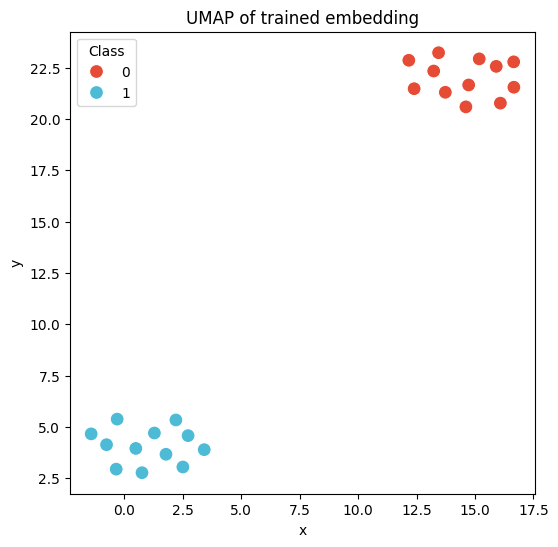

In [7]:
labels = [0]*12+[1]*12
view_embedding(model, class_1_processed+class_2_processed, labels)

## Visualization

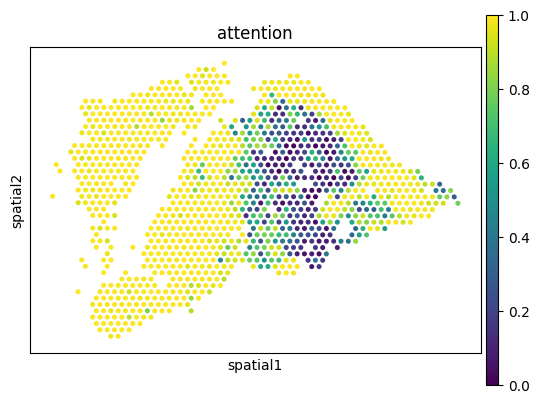

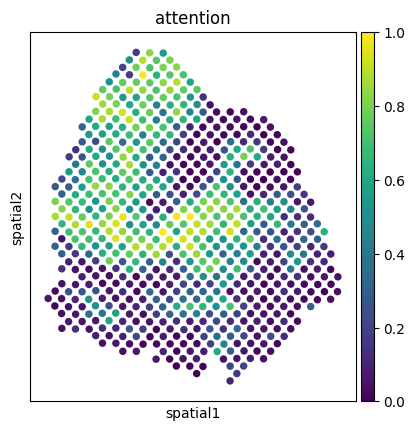

In [8]:
view_pattern(model, class_1_processed[0], spot_size=200)
view_pattern(model, class_2_processed[3], spot_size=200)